In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

I take a curriculum approach to training here. I first expose the model to as many different images of whales as quickly as possible (no oversampling) and train on images resized to 224x224.

I would like the conv layers to start picking up on features useful for identifying whales. For that, I want to show the model as rich of a dataset as possible.

I then train on images resized to 448x448.

Finally, I train on oversampled data. Here, the model will see some images more often than others but I am hoping that this will help alleviate the class imbalance in the training data.

In [3]:
#import fastai
#from fastprogress import force_console_behavior
#import fastprogress
#fastprogress.fastprogress.NO_BAR = True
#master_bar, progress_bar = force_console_behavior()
#fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [4]:
df = pd.read_csv('data/train.csv')
val_fns = {'69823499d.jpg'}

In [5]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [6]:
name = f'res50-full-train'

In [7]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

In [8]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [9]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [10]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [11]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], callback_fns=[ShowGraph])

learn.clip_grad();
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss
1,7.534263,3.004655
2,6.692117,0.719077
3,6.093122,0.000954
4,5.188596,0.000192
5,4.215767,0.029722
6,3.401028,0.000347
7,2.649823,0.018137
8,1.900703,0.000104
9,1.170811,0.001084
10,0.715557,0.000327


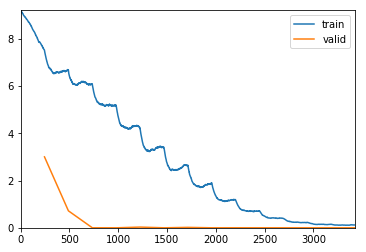

CPU times: user 15min 29s, sys: 7min 21s, total: 22min 50s
Wall time: 23min 4s


In [12]:
%%time

learn.fit_one_cycle(14, 1e-2)
learn.save(f'{name}-stage-1')

In [13]:
learn.load(f'{name}-stage-1');

In [14]:
learn.callback_fns.append(partial(SaveModel, name=f'{name}-stage-2', every='improvement', monitor='trn_loss'))

In [15]:
learn.unfreeze()

In [16]:
max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

epoch,train_loss,valid_loss
1,0.113982,0.000005
2,0.121239,0.000016
3,0.144157,0.000001
4,0.174571,0.000011
5,0.216358,0.000008
6,0.235152,0.000228
7,0.285564,0.000013
8,0.300737,0.000002
9,0.281077,0.000000
10,0.259589,0.000001


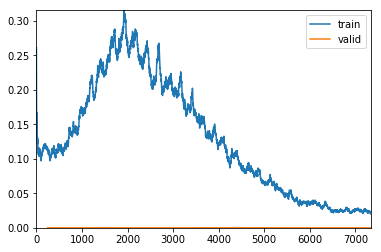

CPU times: user 43min 46s, sys: 20min 49s, total: 1h 4min 35s
Wall time: 1h 5min 27s


In [17]:
%%time

learn.fit_one_cycle(30, lrs)

In [12]:
SZ = 512 #224 * 2
BS = 12
NUM_WORKERS = 8
SEED=0

In [13]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [14]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], callback_fns=[ShowGraph])
learn.clip_grad();

In [14]:
learn.load(f'{name}-stage-2')
learn.freeze_to(-1)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.callback_fns.append(partial(SaveModel, name=f'{name}-stage-3', every='improvement', monitor='trn_loss'))

epoch,train_loss,valid_loss
1,2.942327,0.000074
2,1.431752,0.000004
3,1.437679,0.000106
4,2.027373,0.000158
5,2.569944,0.000281
6,3.432468,0.000000
7,3.964986,0.000012
8,3.971123,0.007527
9,4.297993,0.000000
10,4.644564,0.002488


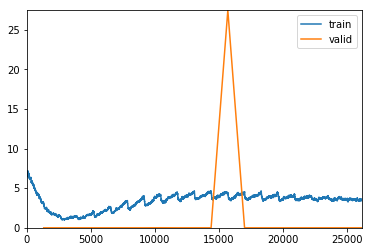

CPU times: user 1h 48min 4s, sys: 50min 10s, total: 2h 38min 15s
Wall time: 2h 38min 38s


In [22]:
%%time

learn.fit_one_cycle(16, 1e-2 / 4) # should probably be lower
learn.callback_fns.pop()

In [23]:
learn.unfreeze()
learn.callback_fns.append(partial(SaveModel, name=f'{name}-stage-4', every='improvement', monitor='trn_loss'))

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

epoch,train_loss,valid_loss
1,1.042950,0.000001
2,0.983125,0.000006
3,0.833992,0.000003
4,0.773729,0.000000
5,0.733849,0.000000
6,0.702803,0.000037
7,0.687984,0.000002
8,0.663247,0.000000
9,0.695676,0.000016
10,0.721491,0.000004


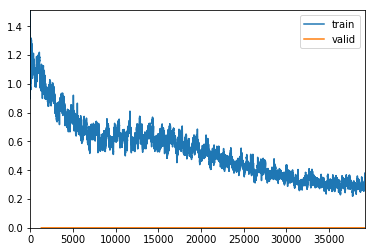

CPU times: user 3h 45min 26s, sys: 1h 45min 24s, total: 5h 30min 50s
Wall time: 5h 32min 9s


In [24]:
%%time

learn.fit_one_cycle(30, lrs)

In [27]:
# with oversampling
df = pd.read_csv('data/oversampled_train_and_val.csv')

In [28]:
data = (
    ImageItemList
        .from_df(df, f'data/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder(f'data/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [24]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], callback_fns=[ShowGraph])
learn.clip_grad();

learn.load(f'{name}-stage-4');
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


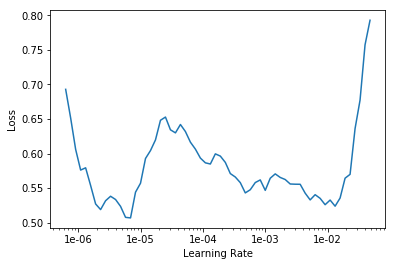

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.callback_fns.append(partial(SaveModel, name=f'{name}-stage-5', every='improvement', monitor='trn_loss'))

epoch,train_loss,valid_loss
1,0.670160,0.000004
2,0.475580,0.000001


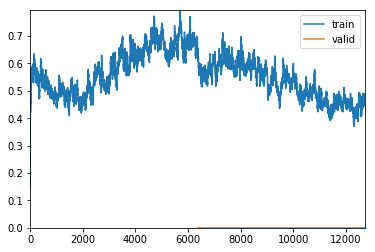

CPU times: user 49min 52s, sys: 22min 45s, total: 1h 12min 38s
Wall time: 1h 12min 45s


In [21]:
%%time

learn.fit_one_cycle(2, 1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


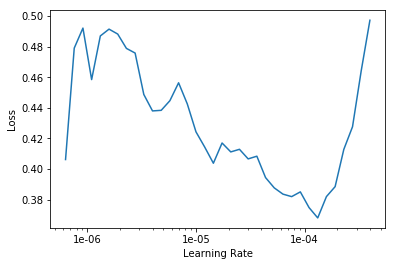

In [27]:
learn.callback_fns.pop()
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.callback_fns.append(partial(SaveModel, name=f'{name}-stage-6', every='improvement', monitor='trn_loss'))

In [29]:
max_lr = 1e-4 / 4
lrs = [max_lr/100, max_lr/10, max_lr]
learn.lr_range(lrs)

[2.5e-07, 2.5e-06, 2.5e-05]

epoch,train_loss,valid_loss
1,0.424235,0.000000
2,0.297060,0.000002
3,0.350161,0.000003
4,0.346388,0.000004


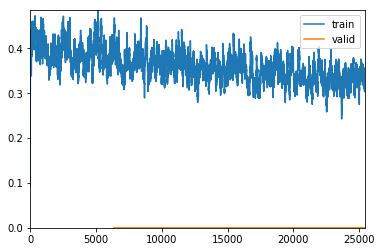

CPU times: user 2h 26min 37s, sys: 1h 9min 50s, total: 3h 36min 28s
Wall time: 3h 37min 15s


In [30]:
%%time

learn.fit_one_cycle(4, lrs)

## Predict

In [31]:
learn.load(f'{name}-stage-6');

In [32]:
preds, _ = learn.get_preds(DatasetType.Test)

In [33]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [65]:
preds[:, 5004] = 0.2

In [66]:
classes = learn.data.classes + ['new_whale']

In [67]:
create_submission(preds, learn.data, f'{name}-stage-6', classes)

In [71]:
pd.read_csv(f'subs/{name}-stage-6.csv.gz').head()

,Image,Id
0,00028a005.jpg,w_dec7ffd new_whale w_e32ad9c w_6b1bd76 w_1f1cee1
1,000dcf7d8.jpg,w_e3956f5 w_4132bb8 new_whale w_c1b90d1 w_a2a40d2
2,000e7c7df.jpg,w_94c3bf0 new_whale w_4c218b5 w_a743e09 w_c1715f5
3,0019c34f4.jpg,w_a335fc2 new_whale w_59052ad w_c99807e w_0c69117
4,001a4d292.jpg,w_927dcdc new_whale w_5688262 w_9e18daa w_e3ced4e


In [73]:
pd.read_csv(f'subs/{name}-stage-6.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.3949748743718593

In [19]:
#!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 183k/183k [00:04<00:00, 37.6kB/s]
Successfully submitted to Humpback Whale Identification